In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import random
import numpy as np
import torch


from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.networks.layers.factories import Act, Norm

from monai.config import print_config
from monai.metrics import DiceMetric
# from src.models.swincspunetr import SwinCSPUNETR
# from src.models.swincspunetr_unet import SwinCSPUNETR_unet
# from src.models.swincspunetr3plus import SwinCSPUNETR3plus

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# 랜덤 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


print_config()

c:\ProgramData\anaconda3\envs\czii\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.26.3
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\ProgramData\anaconda3\envs\czii\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.15.1
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.1
pandas version: 2.2.3
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For d

In [2]:
# class_info = {
#     0: {"name": "background", "weight": 0},  # weight 없음
#     1: {"name": "apo-ferritin", "weight": 1000},
#     2: {"name": "beta-amylase", "weight": 100}, # 4130
#     3: {"name": "beta-galactosidase", "weight": 1500}, #3080
#     4: {"name": "ribosome", "weight": 1000},
#     5: {"name": "thyroglobulin", "weight": 1500},
#     6: {"name": "virus-like-particle", "weight": 1000},
# }

# # 가중치에 비례한 비율 계산
# raw_ratios = {
#     k: (v["weight"] if v["weight"] is not None else 0.01)  # 가중치 비례, None일 경우 기본값a
#     for k, v in class_info.items()
# }
# total = sum(raw_ratios.values())
# ratios = {k: v / total for k, v in raw_ratios.items()}

# # 최종 합계가 1인지 확인
# final_total = sum(ratios.values())
# print("클래스 비율:", ratios)
# print("최종 합계:", final_total)

# # 비율을 리스트로 변환
# ratios_list = [ratios[k] for k in sorted(ratios.keys())]
# print("클래스 비율 리스트:", ratios_list)

# 모델 설정

In [3]:
from src.dataset.dataset import create_dataloaders, create_dataloaders_bw
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    Orientationd, CropForegroundd, GaussianSmoothd, ScaleIntensityd,
    RandSpatialCropd, RandRotate90d, RandFlipd, RandGaussianNoised,
    ToTensord, RandCropByLabelClassesd, RandCropByPosNegLabeld, RandCropd, RandSpatialCrop, RandGaussianSmoothd
)
from monai.transforms import CastToTyped
import numpy as np

train_csv = './datasets/denoise_train.csv'
val_csv = './datasets/denoise_val.csv'

# DATA CONFIG
img_size =  96 # Match your patch size
img_depth = img_size
n_classes = 1
batch_size = 16 # 13.8GB GPU memory required for 128x128 img size
loader_batch = 1
num_samples = batch_size // loader_batch # 한 이미지에서 뽑을 샘플 수
num_repeat = 10
# MODEL CONFIG
num_epochs = 4000
lamda = 0.5
ce_weight = 0.4
lr = 0.001
feature_size = 48
use_checkpoint = True
use_v2 = True
drop_rate= 0.2
attn_drop_rate = 0.2
num_bottleneck = 2
# CLASS_WEIGHTS
class_weights = None
# class_weights = torch.tensor([0.0001, 1, 0.001, 1.1, 1, 1.1, 1], dtype=torch.float32)  # 클래스별 가중치
sigma = 1.5
accumulation_steps = 1
# INIT
start_epoch = 0
best_val_loss = float('inf')
best_val_fbeta_score = 0

non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
# )
])
# val_non_random_transforms = Compose([
#     EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
#     NormalizeIntensityd(keys=["image", "label"], nonzero=True, channel_wise=True),
#     Orientationd(keys=["image", "label"], axcodes="RAS"),
# ])
random_transforms = Compose([
    RandCropd(
        keys=["image", "label"],
        cropper=RandSpatialCrop(roi_size=[img_depth, img_size, img_size], random_center=True, random_size=False)
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandGaussianSmoothd(
    keys=["image"],      # 변환을 적용할 키
    sigma_x = (0.5, sigma), # 각 축(x, y, z)의 시그마 값
    sigma_y = (0.5, sigma),
    sigma_z = (0.5, sigma),
    prob=0.5,
    )  
])
val_random_transforms = Compose([
    RandCropd(
        keys=["image", "label"],
        cropper=RandSpatialCrop(roi_size=[img_depth, img_size, img_size], random_center=True, random_size=False)
    ),
    # RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    # RandGaussianNoise(prob=0.5, mean=0.0, std=0.1),
])


In [4]:
from src.dataset.dataset_csv import create_dataloaders_from_csv
train_loader, val_loader = None, None
train_loader, val_loader = create_dataloaders_from_csv(
    train_csv,
    val_csv, 
    train_non_random_transforms = non_random_transforms, 
    val_non_random_transforms=non_random_transforms,
    train_random_transforms=random_transforms, 
    val_random_transforms=val_random_transforms,
    batch_size = loader_batch,
    num_workers=0,
    train_num_repeat=num_repeat,
    val_num_repeat=num_repeat,
    )

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  6.18it/s]


https://monai.io/model-zoo.html

In [5]:
from monai.losses import TverskyLoss
import torch
import torch.nn as nn

criterion = nn.MSELoss()  # 또는 nn.L1Loss()

In [6]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
from pathlib import Path
from monai.networks.nets import UNet
from torch.nn import Sigmoid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=1,
    dropout = drop_rate,
    norm = Norm.INSTANCE,
    act = Act.PRELU 
).to(device)

pretrain_str = "yes" if use_checkpoint else "no"
weight_str = "weighted" if class_weights is not None else ""

# 체크포인트 디렉토리 및 파일 설정
checkpoint_base_dir = Path("./model_checkpoints")
folder_name = f"Denoising_UNet5_randnoise_{weight_str}_f{feature_size}_d{img_depth}s{img_size}_numb{num_bottleneck}_lr{lr:.0e}_a{lamda:.2f}_b{1-lamda:.2f}_b{batch_size}_r{num_repeat}_ce{ce_weight}_ac{accumulation_steps}"
checkpoint_dir = checkpoint_base_dir / folder_name
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
# 체크포인트 디렉토리 생성
checkpoint_dir.mkdir(parents=True, exist_ok=True)

if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint= None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

In [7]:
batch = next(iter(val_loader))
images, labels = batch["image"], batch["label"]
print(images.shape, labels.shape)

torch.Size([1, 1, 96, 96, 96]) torch.Size([1, 1, 96, 96, 96])


In [8]:
torch.backends.cudnn.benchmark = True

In [9]:
import wandb
from datetime import datetime

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = folder_name

# wandb 초기화
wandb.init(
    project='czii',  # 프로젝트 이름 설정
    name=run_name,         # 실행(run) 이름 설정
    config={
        'num_epochs': num_epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'lambda': lamda,
        # "cross_entropy_weight": ce_weight,
        'feature_size': feature_size,
        'img_size': img_size,
        # 'sampling_ratio': ratios_list,
        'device': device.type,
        "checkpoint_dir": str(checkpoint_dir),
        "class_weights": class_weights.tolist() if class_weights is not None else None,
        # "use_checkpoint": use_checkpoint,
        "drop_rate": drop_rate,
        # "attn_drop_rate": attn_drop_rate,
        # "use_v2": use_v2,
        "accumulation_steps": accumulation_steps,
        "num_repeat": num_repeat,
        # "num_bottleneck": num_bottleneck,
        
        # 필요한 하이퍼파라미터 추가
    }
)
# 모델을 wandb에 연결
wandb.watch(model, log='all')

wandb: Currently logged in as: woow070840 (waooang). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# 학습

In [10]:
# from monai.metrics import DiceMetric
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
    
def processing(batch_data, model, criterion, device):
    images = batch_data['image'].to(device)  # Input 이미지 (B, 1, 96, 96, 96)
    labels = batch_data['label'].to(device)  # 라벨 (B, 1, 96, 96, 96)
    
    # print("shape:", images.shape, labels.shape)

    labels = labels.float()  # 라벨을 float형으로 변환
    # print("shape:", images.shape, labels.shape)

    # 모델 예측
    outputs = model(images)  # outputs: (B, 1, 96, 96, 96)

    # Loss 계산
    loss = criterion(outputs, labels)
    return loss, outputs, labels

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, accumulation_steps=4):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()  # 그래디언트 초기화
    with tqdm(train_loader, desc='Training') as pbar:
        for i, batch_data in enumerate(pbar):
            # 손실 계산
            loss, _, _ = processing(batch_data, model, criterion, device)

            # 그래디언트를 계산하고 누적
            loss = loss / accumulation_steps  # 그래디언트 누적을 위한 스케일링
            loss.backward()  # 그래디언트 계산 및 누적
            
            # 그래디언트 업데이트 (accumulation_steps마다 한 번)
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()  # 파라미터 업데이트
                optimizer.zero_grad()  # 누적된 그래디언트 초기화
            
            # 손실값 누적 (스케일링 복구)
            epoch_loss += loss.item() * accumulation_steps  # 실제 손실값 반영
            pbar.set_postfix(loss=loss.item() * accumulation_steps)  # 실제 손실값 출력
    avg_loss = epoch_loss / len(train_loader)
    wandb.log({'train_epoch_loss': avg_loss, 'epoch': epoch + 1})
    return avg_loss

# PSNR을 계산하는 함수
def calculate_psnr(pred, target):
    """
    PSNR을 계산하는 함수
    pred: 예측 이미지 (numpy 배열)
    target: 실제 이미지 (numpy 배열)
    """
    pred_np = pred.cpu().numpy()
    target_np = target.cpu().numpy()
    
    # 데이터 범위 확인
    data_range = target_np.max() - target_np.min()
    # print("Data range:", data_range)
    
    # NaN 또는 Inf 값 확인
    # print("NaN in pred:", np.isnan(pred_np).any())
    # print("NaN in target:", np.isnan(target_np).any())
    # print("Inf in pred:", np.isinf(pred_np).any())
    # print("Inf in target:", np.isinf(target_np).any())
    
    # MSE 값 확인
    mse_value = np.mean((target_np - pred_np) ** 2)
    # print("MSE:", mse_value)
    
    psnr_value = psnr(target_np, pred_np, data_range=data_range)
    
    return psnr_value

# 에포크별 검증 함수
def validate_one_epoch(model, val_loader, criterion, device, epoch, calculate_dice_interval):
    model.eval()
    val_loss = 0
    
    psnr_scores = []
    ssim_scores = []
    with torch.no_grad():
        with tqdm(val_loader, desc='Validation') as pbar:
            for batch_data in pbar:
                loss, preds, labels = processing(batch_data, model, criterion, device)
                val_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

                # PSNR, SSIM 계산
                if epoch % calculate_dice_interval == 0:
                    psnr_value = calculate_psnr(preds, labels)
                    
                    # PSNR, SSIM 값을 로깅
                    wandb.log({'psnr': psnr_value, 'epoch': epoch + 1})
                    # wandb.log({'ssim': ssim_value, 'epoch': epoch + 1})
                    print(f"PSNR: {psnr_value:.4f},", end=", ")
                    
                    psnr_scores.append(psnr_value)
                    # ssim_scores.append(ssim_value)

    avg_loss = val_loss / len(val_loader)
    # 에포크별 평균 손실 로깅
    wandb.log({'val_epoch_loss': avg_loss, 'epoch': epoch + 1})
    
    if epoch % calculate_dice_interval == 0:
        print("Validation PSNR and SSIM Scores")
        overall_mean_psnr = np.mean(psnr_scores)
        # overall_mean_ssim = np.mean(ssim_scores)
        wandb.log({'overall_mean_psnr': overall_mean_psnr, 'epoch': epoch + 1})
        print(f"\nOverall Mean PSNR: {overall_mean_psnr:.4f}\n")

    # if overall_mean_fbeta is None:
    #     overall_mean_fbeta = 0

    # 시각화 코드
    # 예측과 라벨을 시각화
    
    # preds = preds.cpu().numpy()
    # labels = labels.cpu().numpy()
    # preds = np.squeeze(preds, axis=0)
    # preds = np.squeeze(preds, axis=0)
    # labels = np.squeeze(labels, axis=0)
    # labels = np.squeeze(labels, axis=0)
    # # print(preds.shape, labels.shape)
    
    # slice_idx = 50
    # plt.figure(figsize=(10, 5))

    # # Image 1 비교
    # plt.subplot(1, 2, 1)
    # plt.imshow(preds[slice_idx], cmap="gray")
    # plt.title("Image: Original")
    # plt.axis("off")

    # plt.subplot(1, 2, 2)
    # plt.imshow(labels[slice_idx], cmap="gray")
    # plt.title("Label: denoised")
    # plt.axis("off")
    # plt.show()
    
    return val_loss / len(val_loader), overall_mean_psnr

def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, 
    device, start_epoch, best_val_loss, best_val_fbeta_score=0, calculate_dice_interval=1,
    accumulation_steps=4
):
    """
    모델을 학습하고 검증하는 함수
    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        criterion: 손실 함수
        optimizer: 최적화 알고리즘
        num_epochs: 총 학습 epoch 수
        patience: early stopping 기준
        device: GPU/CPU 장치
        start_epoch: 시작 epoch
        best_val_loss: 이전 최적 validation loss
        best_val_fbeta_score: 이전 최적 validation f-beta score
        calculate_dice_interval: Dice 점수 계산 주기
    """
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train One Epoch
        train_loss = train_one_epoch(
            model=model, 
            train_loader=train_loader, 
            criterion=criterion, 
            optimizer=optimizer, 
            device=device,
            epoch=epoch,
            accumulation_steps= accumulation_steps
        )
        
        scheduler.step(train_loss)
        # Validate One Epoch
        val_loss, overall_mean_psnr = validate_one_epoch(
            model=model, 
            val_loader=val_loader, 
            criterion=criterion, 
            device=device, 
            epoch=epoch, 
            calculate_dice_interval=calculate_dice_interval
        )

        
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation PSNR: {overall_mean_psnr:.4f}")

        if val_loss < best_val_loss and overall_mean_psnr > best_val_fbeta_score:
            best_val_loss = val_loss
            best_val_fbeta_score = overall_mean_psnr
            epochs_no_improve = 0
            checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            print(f"========================================================")
            print(f"SUPER Best model saved. Loss:{best_val_loss:.4f}, Score:{best_val_fbeta_score:.4f}")
            print(f"========================================================")

        # Early stopping 조건 체크
        if val_loss >= best_val_loss and overall_mean_psnr <= best_val_fbeta_score:
            epochs_no_improve += 1
        else:
            epochs_no_improve = 0

        if epochs_no_improve >= patience:
            print("Early stopping")
            checkpoint_path = os.path.join(checkpoint_dir, 'last.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            break
        # if epochs_no_improve%6 == 0 & epochs_no_improve != 0:
        #     # 손실이 개선되지 않았으므로 lambda 감소
        #     new_lamda = max(criterion.lamda - 0.01, 0.35)  # 최소값은 0.1로 설정
        #     criterion.set_lamda(new_lamda)
        #     print(f"Validation loss did not improve. Reducing lambda to {new_lamda:.4f}")

    wandb.finish()


In [11]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=5,
    device=device,
    start_epoch=start_epoch,
    best_val_loss=best_val_loss,
    best_val_fbeta_score=best_val_fbeta_score,
    calculate_dice_interval=1,
    accumulation_steps = accumulation_steps
     ) 

Epoch 1/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  5.16it/s, loss=0.11] 

PSNR: 30.5713,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.85it/s, loss=0.103]

PSNR: 31.6820,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.58it/s, loss=0.103]

PSNR: 32.3020,, 

Validation:  40%|████      | 4/10 [00:01<00:01,  4.54it/s, loss=0.123]

PSNR: 31.9062,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.69it/s, loss=0.123]

PSNR: 29.8093,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.51it/s, loss=0.344]

PSNR: 28.9840,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.49it/s, loss=0.146]

PSNR: 30.2827,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.41it/s, loss=0.11] 

PSNR: 31.7051,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.41it/s, loss=0.103]

PSNR: 32.4584,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.49it/s, loss=0.149]


PSNR: 31.3752,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.1076

Training Loss: 0.3770, Validation Loss: 0.1420, Validation PSNR: 31.1076
SUPER Best model saved. Loss:0.1420, Score:31.1076
Epoch 2/4000


Validation:  10%|█         | 1/10 [00:00<00:02,  4.49it/s, loss=0.1]

PSNR: 32.8245,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.63it/s, loss=0.137] 

PSNR: 33.7947,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.64it/s, loss=0.137]

PSNR: 32.2037,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.90it/s, loss=0.0938]

PSNR: 34.2971,, PSNR: 32.5106,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.92it/s, loss=0.188] 

PSNR: 31.5506,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.83it/s, loss=0.226]

PSNR: 28.6882,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.68it/s, loss=0.0869]

PSNR: 33.3934,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.73it/s, loss=0.106] 

PSNR: 32.1252,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.70it/s, loss=0.1] 


PSNR: 33.7050,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.5093

Training Loss: 0.2463, Validation Loss: 0.1207, Validation PSNR: 32.5093
SUPER Best model saved. Loss:0.1207, Score:32.5093
Epoch 3/4000


Validation:  10%|█         | 1/10 [00:00<00:02,  4.16it/s, loss=0.13]

PSNR: 32.1427,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.30it/s, loss=0.491]

PSNR: 25.9651,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.70it/s, loss=0.0785]

PSNR: 33.6506,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.52it/s, loss=0.0816]

PSNR: 32.9075,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.44it/s, loss=0.126] 

PSNR: 31.1385,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.40it/s, loss=0.102]

PSNR: 30.9681,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.52it/s, loss=0.0941]

PSNR: 32.8073,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.48it/s, loss=0.105] 

PSNR: 31.2816,, 

Validation:  90%|█████████ | 9/10 [00:02<00:00,  4.55it/s, loss=0.0718]

PSNR: 34.3287,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s, loss=0.139]


PSNR: 30.6482,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.5838

Training Loss: 0.2170, Validation Loss: 0.1418, Validation PSNR: 31.5838
Epoch 4/4000


Validation:  10%|█         | 1/10 [00:00<00:02,  4.42it/s, loss=0.0614]

PSNR: 35.0847,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.34it/s, loss=0.099] 

PSNR: 33.9918,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.69it/s, loss=0.099]

PSNR: 31.5451,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.64it/s, loss=0.0595]

PSNR: 34.2502,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.31it/s, loss=0.177] 

PSNR: 30.4418,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.48it/s, loss=0.116]

PSNR: 30.4538,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.41it/s, loss=0.142]

PSNR: 31.6491,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.45it/s, loss=0.0672]

PSNR: 34.1601,, 

Validation:  90%|█████████ | 9/10 [00:02<00:00,  4.36it/s, loss=0.074] 

PSNR: 32.8212,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, loss=0.0616]


PSNR: 35.0811,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.9479

Training Loss: 0.1936, Validation Loss: 0.0921, Validation PSNR: 32.9479
SUPER Best model saved. Loss:0.0921, Score:32.9479
Epoch 5/4000


Validation:  10%|█         | 1/10 [00:00<00:02,  4.42it/s, loss=0.213]

PSNR: 26.7837,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.60it/s, loss=0.0745]

PSNR: 33.7289,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.70it/s, loss=0.0745]

PSNR: 34.7954,, 

Validation:  40%|████      | 4/10 [00:01<00:01,  4.62it/s, loss=0.0627]

PSNR: 34.9651,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.69it/s, loss=0.0627]

PSNR: 34.0743,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.58it/s, loss=0.311] 

PSNR: 27.4208,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.60it/s, loss=0.113]

PSNR: 31.7229,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.80it/s, loss=0.127]

PSNR: 32.4190,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.81it/s, loss=0.127]

PSNR: 31.7557,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.66it/s, loss=0.0992]


PSNR: 31.2499,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.8916

Training Loss: 0.2157, Validation Loss: 0.1242, Validation PSNR: 31.8916
Epoch 6/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  4.78it/s, loss=0.149] 

PSNR: 32.5859,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.82it/s, loss=0.149]

PSNR: 30.7346,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.57it/s, loss=0.0589]

PSNR: 35.9173,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.62it/s, loss=0.0972]

PSNR: 33.2466,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.59it/s, loss=0.0875]

PSNR: 32.9950,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.65it/s, loss=0.0875]

PSNR: 33.2258,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.62it/s, loss=0.177] 

PSNR: 28.6594,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.67it/s, loss=0.08] 

PSNR: 34.6814,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.60it/s, loss=0.125]

PSNR: 32.7281,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.65it/s, loss=0.135]


PSNR: 30.8297,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.5604

Training Loss: 0.1869, Validation Loss: 0.1086, Validation PSNR: 32.5604
Epoch 7/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  4.81it/s, loss=0.0999]

PSNR: 33.7197,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.84it/s, loss=0.155] 

PSNR: 30.4098,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.68it/s, loss=0.116]

PSNR: 28.5960,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.75it/s, loss=0.116]

PSNR: 30.2164,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.65it/s, loss=0.12] 

PSNR: 32.9112,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.66it/s, loss=0.0784]

PSNR: 32.7765,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.59it/s, loss=0.0618]

PSNR: 35.1136,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.61it/s, loss=0.145] 

PSNR: 30.9206,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.72it/s, loss=0.0712]


PSNR: 33.2518,, PSNR: 35.0946,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.3010

Training Loss: 0.1896, Validation Loss: 0.1125, Validation PSNR: 32.3010
Epoch 8/4000


Validation:  20%|██        | 2/10 [00:00<00:01,  5.07it/s, loss=0.0641]

PSNR: 33.2960,, PSNR: 33.8132,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  5.09it/s, loss=0.0989]

PSNR: 32.7072,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.82it/s, loss=0.0615]

PSNR: 35.4208,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.69it/s, loss=0.054] 

PSNR: 34.5196,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.74it/s, loss=0.054]

PSNR: 34.7036,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.70it/s, loss=0.0863]

PSNR: 34.4937,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.63it/s, loss=0.0698]

PSNR: 32.8949,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.67it/s, loss=0.0847]

PSNR: 33.4551,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s, loss=0.135]


PSNR: 30.9121,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 33.6216

Training Loss: 0.2052, Validation Loss: 0.0853, Validation PSNR: 33.6216
SUPER Best model saved. Loss:0.0853, Score:33.6216
Epoch 9/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  4.85it/s, loss=0.204]

PSNR: 30.0218,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.71it/s, loss=0.0601]

PSNR: 29.6080,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.71it/s, loss=0.0601]

PSNR: 35.3942,, 

Validation:  40%|████      | 4/10 [00:01<00:01,  4.86it/s, loss=0.0726]

PSNR: 35.0686,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.88it/s, loss=0.0726]

PSNR: 32.8286,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.73it/s, loss=0.0574]

PSNR: 35.5074,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.66it/s, loss=0.0605]

PSNR: 34.4896,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.57it/s, loss=0.168] 

PSNR: 28.3749,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.63it/s, loss=0.124]

PSNR: 31.1855,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s, loss=0.331]


PSNR: 28.2490,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.0728

Training Loss: 0.2542, Validation Loss: 0.1324, Validation PSNR: 32.0728
Epoch 10/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  5.09it/s, loss=0.0975]

PSNR: 30.8435,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  5.15it/s, loss=0.0975]

PSNR: 31.5602,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.76it/s, loss=0.367] 

PSNR: 27.4140,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.74it/s, loss=0.121]

PSNR: 31.8042,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.59it/s, loss=0.579]

PSNR: 26.3157,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.58it/s, loss=0.111]

PSNR: 31.1976,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.57it/s, loss=0.0832]

PSNR: 33.6450,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.43it/s, loss=0.193] 

PSNR: 28.4178,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.36it/s, loss=0.274]

PSNR: 27.6931,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, loss=0.209]


PSNR: 29.1218,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 29.8013

Training Loss: 0.2069, Validation Loss: 0.2130, Validation PSNR: 29.8013
Epoch 11/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  4.85it/s, loss=0.0593]

PSNR: 34.8637,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.71it/s, loss=0.0613]

PSNR: 33.2707,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.60it/s, loss=0.0662]

PSNR: 34.6614,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.66it/s, loss=0.0662]

PSNR: 34.8963,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.57it/s, loss=0.0509]

PSNR: 35.9414,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.56it/s, loss=0.079] 

PSNR: 32.1338,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.78it/s, loss=0.125] 

PSNR: 32.6416,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.89it/s, loss=0.125]

PSNR: 31.0702,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.67it/s, loss=0.0964]

PSNR: 32.7991,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.68it/s, loss=0.135]


PSNR: 30.1895,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 33.2468

Training Loss: 0.1524, Validation Loss: 0.0818, Validation PSNR: 33.2468
Epoch 12/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  4.92it/s, loss=0.103]

PSNR: 34.4346,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.75it/s, loss=0.155]

PSNR: 30.4333,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.64it/s, loss=0.0545]

PSNR: 34.5556,, 

Validation:  40%|████      | 4/10 [00:01<00:01,  4.53it/s, loss=0.05]  

PSNR: 28.8142,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.61it/s, loss=0.05]

PSNR: 35.6102,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.54it/s, loss=0.0594]

PSNR: 32.4940,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.68it/s, loss=0.0594]

PSNR: 33.9426,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.54it/s, loss=0.533] 

PSNR: 24.9395,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.63it/s, loss=0.0757]

PSNR: 33.3387,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s, loss=0.0675]


PSNR: 34.3893,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.2952

Training Loss: 0.1558, Validation Loss: 0.1426, Validation PSNR: 32.2952
Epoch 13/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  5.02it/s, loss=0.0621]

PSNR: 35.3404,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.94it/s, loss=0.0591]

PSNR: 36.2193,, PSNR: 35.8042,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.86it/s, loss=0.124] 

PSNR: 31.9930,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.87it/s, loss=0.173]

PSNR: 30.5986,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.60it/s, loss=0.105]

PSNR: 32.3170,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.66it/s, loss=0.12] 

PSNR: 30.8039,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.54it/s, loss=0.0672]

PSNR: 34.4612,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.58it/s, loss=0.0609]

PSNR: 34.4846,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s, loss=0.071]


PSNR: 32.8589,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 33.4881

Training Loss: 0.1604, Validation Loss: 0.0897, Validation PSNR: 33.4881
Epoch 14/4000


Validation:  10%|█         | 1/10 [00:00<00:02,  4.49it/s, loss=0.062]

PSNR: 33.7616,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.34it/s, loss=0.0761]

PSNR: 34.3357,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.81it/s, loss=0.0761]

PSNR: 32.4489,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.85it/s, loss=0.119] 

PSNR: 32.0899,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.64it/s, loss=0.0557]

PSNR: 35.3120,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.59it/s, loss=0.0792]

PSNR: 28.1862,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.58it/s, loss=0.0792]

PSNR: 33.5228,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.55it/s, loss=0.117] 

PSNR: 30.9609,, 

Validation:  90%|█████████ | 9/10 [00:02<00:00,  4.60it/s, loss=0.12] 

PSNR: 31.3449,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.66it/s, loss=0.12]


PSNR: 31.1200,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.3083

Training Loss: 0.1597, Validation Loss: 0.1095, Validation PSNR: 32.3083
Epoch 15/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  5.01it/s, loss=0.0749]

PSNR: 34.8909,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.74it/s, loss=0.0662]

PSNR: 34.5752,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.61it/s, loss=0.0991]

PSNR: 37.5486,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.65it/s, loss=0.0991]

PSNR: 32.1892,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.60it/s, loss=0.0597]

PSNR: 33.6378,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.64it/s, loss=0.0804]

PSNR: 32.0377,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.56it/s, loss=0.0513]

PSNR: 35.7475,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.58it/s, loss=0.0608]

PSNR: 34.5947,, 

Validation:  90%|█████████ | 9/10 [00:02<00:00,  4.41it/s, loss=0.0918]

PSNR: 34.3887,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s, loss=0.0918]


PSNR: 33.7397,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 34.3350

Training Loss: 0.1876, Validation Loss: 0.0720, Validation PSNR: 34.3350
SUPER Best model saved. Loss:0.0720, Score:34.3350
Epoch 16/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  4.70it/s, loss=0.11] 

PSNR: 31.2346,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.83it/s, loss=0.11]

PSNR: 32.5023,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.74it/s, loss=0.0722]

PSNR: 35.6601,, PSNR: 34.6020,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.97it/s, loss=0.148] 

PSNR: 30.3902,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.88it/s, loss=0.102]

PSNR: 31.0085,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.75it/s, loss=0.238]

PSNR: 32.3292,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.82it/s, loss=0.238]

PSNR: 28.7740,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.69it/s, loss=0.062]

PSNR: 36.0162,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s, loss=0.105]


PSNR: 31.0914,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.3609

Training Loss: 0.1618, Validation Loss: 0.1162, Validation PSNR: 32.3609
Epoch 17/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  4.58it/s, loss=0.0577]

PSNR: 33.8361,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.37it/s, loss=0.0493]

PSNR: 34.9813,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.32it/s, loss=0.103] 

PSNR: 32.3709,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.46it/s, loss=0.0601]

PSNR: 34.6201,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.47it/s, loss=0.0502]

PSNR: 35.0428,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.52it/s, loss=0.0543]

PSNR: 34.6111,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.44it/s, loss=0.0503]

PSNR: 35.9907,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.42it/s, loss=0.0449]

PSNR: 35.8293,, 

Validation:  90%|█████████ | 9/10 [00:02<00:00,  4.39it/s, loss=0.0946]

PSNR: 32.3601,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, loss=0.138]


PSNR: 29.9521,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 33.9594

Training Loss: 0.1451, Validation Loss: 0.0702, Validation PSNR: 33.9594
Epoch 18/4000


Validation:  10%|█         | 1/10 [00:00<00:02,  3.98it/s, loss=0.0775]

PSNR: 32.8855,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.23it/s, loss=0.0624]

PSNR: 34.7936,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.31it/s, loss=0.0752]

PSNR: 31.3668,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.70it/s, loss=0.0752]

PSNR: 33.9698,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.64it/s, loss=0.0767]

PSNR: 33.6276,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.46it/s, loss=0.0849]

PSNR: 31.7752,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.37it/s, loss=0.0963]

PSNR: 31.5549,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.31it/s, loss=0.172] 

PSNR: 29.1817,, 

Validation:  90%|█████████ | 9/10 [00:02<00:00,  4.18it/s, loss=0.0676]

PSNR: 34.9894,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.30it/s, loss=0.0977]


PSNR: 31.9729,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.6117

Training Loss: 0.1607, Validation Loss: 0.0916, Validation PSNR: 32.6117
Epoch 19/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  5.58it/s, loss=0.0959]

PSNR: 32.4031,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  5.06it/s, loss=0.0988]

PSNR: 31.7334,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.75it/s, loss=0.108] 

PSNR: 33.0962,, 

Validation:  40%|████      | 4/10 [00:01<00:01,  4.69it/s, loss=0.223]

PSNR: 32.5021,, PSNR: 27.8418,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.84it/s, loss=0.17] 

PSNR: 30.6703,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.77it/s, loss=0.201]

PSNR: 29.8090,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.60it/s, loss=0.124]

PSNR: 32.3887,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.56it/s, loss=0.124]

PSNR: 32.7789,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.65it/s, loss=0.105]


PSNR: 31.8254,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.5049

Training Loss: 0.2893, Validation Loss: 0.1334, Validation PSNR: 31.5049
Epoch 20/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  4.57it/s, loss=0.0967]

PSNR: 32.1399,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.61it/s, loss=0.156] 

PSNR: 30.7530,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.57it/s, loss=0.108] 

PSNR: 32.7932,, PSNR: 31.4568,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.93it/s, loss=0.12] 

PSNR: 30.4981,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.86it/s, loss=0.0801]

PSNR: 32.8663,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.84it/s, loss=0.0862]

PSNR: 34.9836,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.80it/s, loss=0.0862]

PSNR: 32.1669,, 

Validation:  90%|█████████ | 9/10 [00:01<00:00,  4.71it/s, loss=0.0541]

PSNR: 34.4754,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s, loss=0.13] 


PSNR: 32.3772,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.4510

Training Loss: 0.1985, Validation Loss: 0.0976, Validation PSNR: 32.4510
Epoch 21/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  4.54it/s, loss=0.0571]

PSNR: 33.8070,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.54it/s, loss=0.0824]

PSNR: 32.8890,, 

Validation:  30%|███       | 3/10 [00:00<00:01,  4.44it/s, loss=0.0674]

PSNR: 33.4051,, 

Validation:  40%|████      | 4/10 [00:00<00:01,  4.32it/s, loss=0.12]  

PSNR: 31.3020,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.46it/s, loss=0.0702]

PSNR: 33.4437,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.44it/s, loss=0.0503]

PSNR: 36.0762,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.46it/s, loss=0.111] 

PSNR: 31.5792,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.39it/s, loss=0.0712]

PSNR: 33.7081,, 

Validation:  90%|█████████ | 9/10 [00:02<00:00,  4.45it/s, loss=0.0546]

PSNR: 34.9209,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, loss=0.0567]


PSNR: 34.3050,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 33.5436

Training Loss: 0.1607, Validation Loss: 0.0740, Validation PSNR: 33.5436
Epoch 22/4000


Validation:  10%|█         | 1/10 [00:00<00:01,  4.73it/s, loss=0.135]

PSNR: 31.3579,, 

Validation:  20%|██        | 2/10 [00:00<00:01,  4.77it/s, loss=0.105]

PSNR: 32.6136,, PSNR: 31.6560,, 

Validation:  40%|████      | 4/10 [00:01<00:01,  4.89it/s, loss=0.137]

PSNR: 29.7621,, 

Validation:  50%|█████     | 5/10 [00:01<00:01,  4.80it/s, loss=0.137]

PSNR: 30.8983,, 

Validation:  60%|██████    | 6/10 [00:01<00:00,  4.54it/s, loss=0.177]

PSNR: 30.6924,, 

Validation:  70%|███████   | 7/10 [00:01<00:00,  4.58it/s, loss=0.0705]

PSNR: 34.8897,, 

Validation:  80%|████████  | 8/10 [00:01<00:00,  4.51it/s, loss=0.0987]

PSNR: 31.7418,, 

Validation:  90%|█████████ | 9/10 [00:02<00:00,  4.42it/s, loss=0.13]  

PSNR: 30.5254,, 

Validation: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s, loss=0.13]

PSNR: 31.5167,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.5654

Training Loss: 0.2441, Validation Loss: 0.1308, Validation PSNR: 31.5654
Early stopping


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇███████
overall_mean_psnr,▃▅▄▆▄▅▅▇▅▁▆▅▇▅█▅▇▅▄▅▇▄
psnr,▅▂▅▆▃▇▅▄▄▅▅▅▇▆▅▂▇▁▇▇▅▇▂██▅▄█▃▅▅▇▁▅▄▇▆▄▄▄
train_epoch_loss,█▄▃▂▃▂▂▃▄▃▁▁▁▁▂▂▁▁▅▃▁▄
val_epoch_loss,▅▃▅▂▄▃▃▂▄█▂▅▂▃▁▃▁▂▄▂▁▄
epoch,22
overall_mean_psnr,31.5654
psnr,31.5167
train_epoch_loss,0.2441
val_epoch_loss,0.13081


C:\Users\Seungwoo\AppData\Local\Temp\ipykernel_3972\330198786.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=devi

기존 best model 발견: model_checkpoints\Denoising_Flex_randnoise__f48_d96s96_numb2_lr1e-03_a0.50_b0.50_b16_r10_ce0.4_ac1\best_model.pt
기존 학습된 가중치를 성공적으로 로드했습니다.


Visualizing:  10%|█         | 1/10 [00:00<00:01,  5.29it/s]

Input range: metatensor(-5.3512, device='cuda:0') metatensor(4.9801, device='cuda:0')
Target range: metatensor(-9.7260, device='cuda:0') metatensor(3.5526, device='cuda:0')
Prediction range: metatensor(-11.0881, device='cuda:0') metatensor(3.5272, device='cuda:0')
Unique values: metatensor([-11.0881, -10.8515, -10.5348,  ...,   3.2211,   3.5036,   3.5272],
       device='cuda:0')
Input range: metatensor(-5.6956, device='cuda:0') metatensor(5.2328, device='cuda:0')
Target range: metatensor(-10.5545, device='cuda:0') metatensor(4.0533, device='cuda:0')
Prediction range: metatensor(-11.3899, device='cuda:0') metatensor(3.5058, device='cuda:0')
Unique values: metatensor([-11.3899, -11.3039, -10.8977,  ...,   3.4931,   3.4933,   3.5058],
       device='cuda:0')


Visualizing:  20%|██        | 2/10 [00:00<00:02,  3.40it/s]

Input range: metatensor(-4.4408, device='cuda:0') metatensor(4.8854, device='cuda:0')
Target range: metatensor(-7.2192, device='cuda:0') metatensor(4.4839, device='cuda:0')
Prediction range: metatensor(-8.7975, device='cuda:0') metatensor(4.4610, device='cuda:0')
Unique values: metatensor([-8.7975, -8.6779, -8.2388,  ...,  4.2528,  4.3574,  4.4610],
       device='cuda:0')
Unique values in predictions: [-11.08809   -10.851549  -10.534807  ...   3.2210732   3.5036235
   3.527239 ]


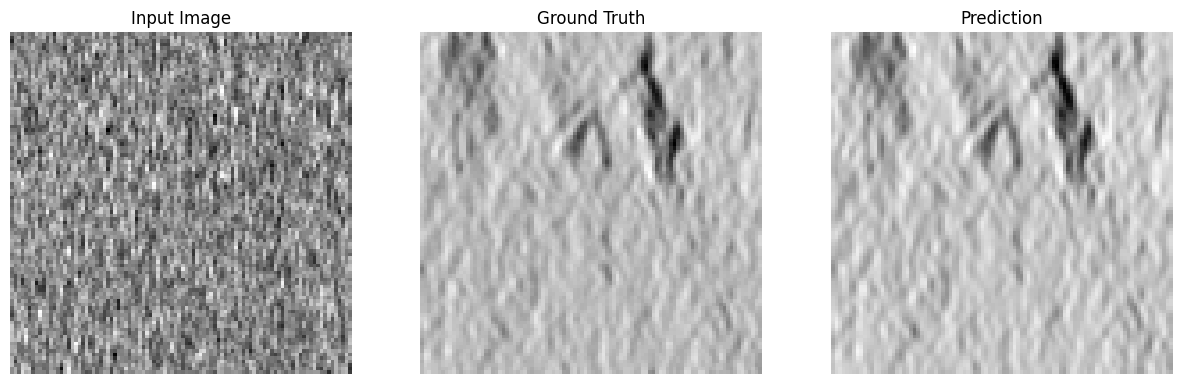

Unique values in predictions: [-11.389933  -11.30393   -10.897719  ...   3.493122    3.4933362
   3.5057726]


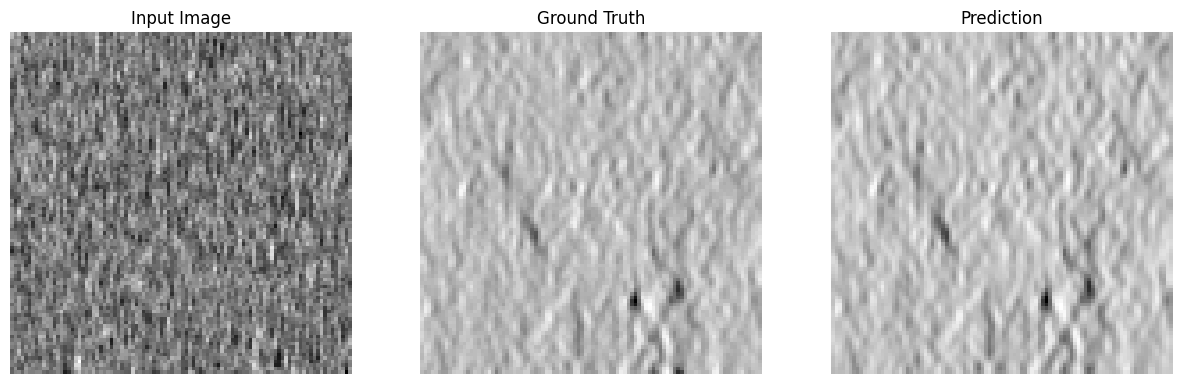

Unique values in predictions: [-8.797539  -8.677935  -8.238844  ...  4.2528114  4.3574386  4.4609594]


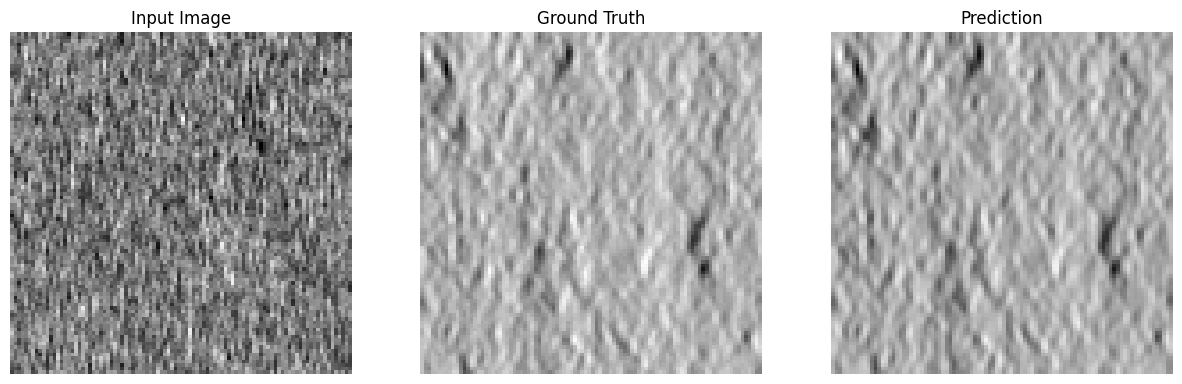

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 최적의 모델 불러오기
def load_best_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# 예측 결과와 실제 라벨 시각화 함수
def visualize_predictions(model, val_loader, device, num_images=5):
    model.eval()
    images, labels, preds = [], [], []
    
    with torch.no_grad():
        for batch_data in tqdm(val_loader, desc='Visualizing'):
            image = batch_data['image'].to(device)
            label = batch_data['label'].to(device)
            
            pred = model(image)
            
            images.append(image.cpu().numpy())
            labels.append(label.cpu().numpy())
            preds.append(pred.cpu().numpy())
            
            print("Input range:", image.min(), image.max())
            print("Target range:", label.min(), label.max())
            print("Prediction range:", pred.min(), pred.max())
            print("Unique values:", torch.unique(pred))
            
            if len(images) >= num_images:
                break
    
    # 시각화
    for i in range(num_images):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Normalize the input image for visualization
        input_image = (images[i][0, 0, :, :, 48] - images[i][0, 0, :, :, 48].min()) / (images[i][0, 0, :, :, 48].max() - images[i][0, 0, :, :, 48].min())
        axes[0].imshow(input_image, cmap='gray')
        axes[0].set_title('Input Image')
        axes[0].axis('off')
        
        axes[1].imshow(labels[i][0, 0, :, 48], cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        
        # 예측 값 확인
        print("Unique values in predictions:", np.unique(preds[i]))
        
        # 데이터 범위 설정
        axes[2].imshow(preds[i][0, 0, :, 48], cmap='gray')
        axes[2].set_title('Prediction')
        axes[2].axis('off')
        
        plt.show()

# 모델 학습 후 최적의 모델 불러오기 및 시각화
model = model  # 모델 정의
val_loader = val_loader  # 검증 데이터 로더
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = os.path.join(checkpoint_dir, 'best_model.pt')  # 저장된 최적의 모델 경로

# 최적의 모델 불러오기
if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint= None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

# 예측 결과와 실제 라벨 시각화
visualize_predictions(model, val_loader, device, num_images=3)

In [13]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)

# VAl

In [ ]:
from monai.data import DataLoader, Dataset, CacheDataset
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    Orientationd, CropForegroundd, GaussianSmoothd, ScaleIntensityd,
    RandSpatialCropd, RandRotate90d, RandFlipd, RandGaussianNoised,
    ToTensord, RandCropByLabelClassesd
)
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, SwinUNETR
from monai.losses import TverskyLoss
import torch
import numpy as np
from tqdm import tqdm
import wandb
from src.dataset.dataset import make_val_dataloader

val_img_dir = "./datasets/val/images"
val_label_dir = "./datasets/val/labels"
img_depth = 96
img_size = 96  # Match your patch size
n_classes = 7
batch_size = 2 # 13.8GB GPU memory required for 128x128 img size
num_samples = batch_size # 한 이미지에서 뽑을 샘플 수
loader_batch = 1
lamda = 0.52

wandb.init(
    project='czii_SwinUnetR_val',  # 프로젝트 이름 설정
    name='SwinUNETR96_96_lr0.001_lambda0.52_batch2',         # 실행(run) 이름 설정
    config={
        'learning_rate': 0.001,
        'batch_size': batch_size,
        'lambda': lamda,
        'img_size': img_size,
        'device': 'cuda',
        "checkpoint_dir": "./model_checkpoints/SwinUNETR96_96_lr0.001_lambda0.52_batch2",
        
    }
)

non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    GaussianSmoothd(
        keys=["image"],      # 변환을 적용할 키
        sigma=[1.0, 1.0, 1.0]  # 각 축(x, y, z)의 시그마 값
        ),
])
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[img_depth, img_size, img_size],
        num_classes=n_classes,
        num_samples=num_samples, 
        ratios=ratios_list,
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
])

val_loader = make_val_dataloader(
    val_img_dir, 
    val_label_dir, 
    non_random_transforms = non_random_transforms, 
    random_transforms = random_transforms, 
    batch_size = loader_batch,
    num_workers=0
)
criterion = TverskyLoss(
    alpha= 1 - lamda,  # FP에 대한 가중치
    beta=lamda,       # FN에 대한 가중치
    include_background=False,  # 배경 클래스 제외
    softmax=True
)
    
    
from monai.metrics import DiceMetric

img_size = 96
img_depth = img_size
n_classes = 7 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrain_path = "./model_checkpoints/SwinUNETR96_96_lr0.001_lambda0.52_batch2/best_model.pt"
model = SwinUNETR(
    img_size=(img_depth, img_size, img_size),
    in_channels=1,
    out_channels=n_classes,
    feature_size=48,
    use_checkpoint=True,
).to(device)
# Pretrained weights 불러오기
checkpoint = torch.load(pretrain_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

val_loss, overall_mean_fbeta_score = validate_one_epoch(
    model=model, 
    val_loader=val_loader, 
    criterion=criterion, 
    device=device, 
    epoch=0, 
    calculate_dice_interval=1
)

class_0_dice_score,▁
class_0_f_beta_score,▁
class_1_dice_score,▁
class_1_f_beta_score,▁
class_2_dice_score,▁
class_2_f_beta_score,▁
class_3_dice_score,▁
class_3_f_beta_score,▁
class_4_dice_score,▁
class_4_f_beta_score,▁
class_5_dice_score,▁


Loading dataset: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]
C:\Users\Seungwoo\AppData\Local\Temp\ipykernel_21000\1177025787.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

Validation Dice Score
Class 0: 0.6570, Class 1: 0.5333, Class 2: 0.0029, Class 3: 0.2370, 
Class 4: 0.6549, Class 5: 0.4790, Class 6: 0.4255, 
Validation F-beta Score
Class 0: 0.5075, Class 1: 0.6470, Class 2: 0.0233, Class 3: 0.2303, 
Class 4: 0.6252, Class 5: 0.5145, Class 6: 0.4720, 
Overall Mean Dice Score: 0.4659
Overall Mean F-beta Score: 0.4978



# Inference

In [ ]:
from src.dataset.preprocessing import Preprocessor

In [ ]:
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, EnsureChannelFirstd, NormalizeIntensityd, Orientationd, GaussianSmoothd
from monai.data import DataLoader, Dataset, CacheDataset
from monai.networks.nets import SwinUNETR
from pathlib import Path
import numpy as np
import copick

import torch
print("Done.")

Done.


In [ ]:
config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
          "name" : "beta-amylase",
            "is_particle": true,
            "pdb_id": "8ZRZ",
            "label": 2,
            "color": [255, 255, 255, 128],
            "radius": 90,
            "map_threshold": 0.0578  
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "./kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "./kaggle/input/czii-cryo-et-object-identification/test/static"
}"""

copick_config_path = "./kaggle/working/copick.config"
preprocessor = Preprocessor(config_blob,copick_config_path=copick_config_path)
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS"),
    GaussianSmoothd(
        keys=["image"],      # 변환을 적용할 키
        sigma=[1.0, 1.0, 1.0]  # 각 축(x, y, z)의 시그마 값
        ),
    ])

Config file written to ./kaggle/working/copick.config
file length: 7


In [ ]:
img_size = 96
img_depth = img_size
n_classes = 7 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrain_path = "./model_checkpoints/SwinUNETR96_96_lr0.001_lambda0.52_batch2/best_model.pt"
model = SwinUNETR(
    img_size=(img_depth, img_size, img_size),
    in_channels=1,
    out_channels=n_classes,
    feature_size=48,
    use_checkpoint=True,
).to(device)
# Pretrained weights 불러오기
checkpoint = torch.load(pretrain_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])


c:\ProgramData\anaconda3\envs\ship\Lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
C:\Users\Seungwoo\AppData\Local\Temp\ipykernel_6248\2937359115.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will

<All keys matched successfully>

In [ ]:
val_loss = validate_one_epoch(
            model=model, 
            val_loader=val_loader, 
            criterion=criterion, 
            device=device, 
            epoch=1, 
            calculate_dice_interval=0
        )

Validation:   0%|          | 0/4 [00:03<?, ?it/s, loss=0.764]


ZeroDivisionError: integer modulo by zero

In [ ]:
import torch
import numpy as np
from scipy.ndimage import label, center_of_mass
import pandas as pd
from tqdm import tqdm
from monai.data import CacheDataset, DataLoader
from monai.transforms import Compose, NormalizeIntensity
import cc3d

def dict_to_df(coord_dict, experiment_name):
    all_coords = []
    all_labels = []
    
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    all_coords = np.vstack(all_coords)
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })
    return df

id_to_name = {1: "apo-ferritin", 
              2: "beta-amylase",
              3: "beta-galactosidase", 
              4: "ribosome", 
              5: "thyroglobulin", 
              6: "virus-like-particle"}
BLOB_THRESHOLD = 200
CERTAINTY_THRESHOLD = 0.05

classes = [1, 2, 3, 4, 5, 6]

model.eval()
with torch.no_grad():
    location_dfs = []  # DataFrame 리스트로 초기화
    
    for vol_idx, run in enumerate(preprocessor.root.runs):
        print(f"Processing volume {vol_idx + 1}/{len(preprocessor.root.runs)}")
        tomogram = preprocessor.processing(run=run, task="task")
        task_files = [{"image": tomogram}]
        task_ds = CacheDataset(data=task_files, transform=non_random_transforms)
        task_loader = DataLoader(task_ds, batch_size=1, num_workers=0)
        
        for task_data in task_loader:
            images = task_data['image'].to("cuda")
            outputs = sliding_window_inference(
                inputs=images,
                roi_size=(96, 96, 96),  # ROI 크기
                sw_batch_size=4,
                predictor=model.forward,
                overlap=0.1,
                sw_device="cuda",
                device="cpu",
                buffer_steps=1,
                buffer_dim=-1
            )
            outputs = outputs.argmax(dim=1).squeeze(0).cpu().numpy()  # 클래스 채널 예측
            location = {}  # 좌표 저장용 딕셔너리
            for c in classes:
                cc = cc3d.connected_components(outputs == c)  # cc3d 라벨링
                stats = cc3d.statistics(cc)
                zyx = stats['centroids'][1:] * 10.012444  # 스케일 변환
                zyx_large = zyx[stats['voxel_counts'][1:] > BLOB_THRESHOLD]  # 크기 필터링
                xyz = np.ascontiguousarray(zyx_large[:, ::-1])  # 좌표 스왑 (z, y, x -> x, y, z)

                location[id_to_name[c]] = xyz  # ID 이름 매칭 저장

            # 데이터프레임 변환
            df = dict_to_df(location, run.name)
            location_dfs.append(df)  # 리스트에 추가
        
        # if vol_idx == 2:
        #     break
    
    # DataFrame 병합
    final_df = pd.concat(location_dfs, ignore_index=True)
    
    # ID 추가 및 CSV 저장
    final_df.insert(loc=0, column='id', value=np.arange(len(final_df)))
    final_df.to_csv("submission.csv", index=False)
    print("Submission saved to: submission.csv")


Processing volume 1/7


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Processing volume 2/7


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Processing volume 3/7


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Submission saved to: submission.csv
